In [1]:
from IPython import display

import tools

import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

from torchvision import transforms, datasets

/Users/diego/.pyenv/versions/miniconda-latest/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

## Load Data

In [3]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [4]:
data = mnist_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

## Networks

In [5]:
class DiscriminativeNet(torch.nn.Module):
    """
    A two hidden-layer discriminative neural network
    """
    def __init__(self, n_features, n_hidden0, n_hidden1, n_hidden2):
        super(DiscriminativeNet, self).__init__()
        self.hidden0 = torch.nn.Linear(n_features, n_hidden0)
        self.hidden1 = torch.nn.Linear(n_hidden0, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out = torch.nn.Linear(n_hidden2, 1)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.2)(self.hidden0(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.LeakyReLU(0.2)(self.hidden1(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.LeakyReLU(0.2)(self.hidden2(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.Sigmoid()(self.out(x))
        return x

In [6]:
class GenerativeNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_features, n_hidden0, n_hidden1, n_hidden2 , n_out):
        super(GenerativeNet, self).__init__()
        self.hidden0 = torch.nn.Linear(n_features, n_hidden0)
        self.hidden1 = torch.nn.Linear(n_hidden0, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out = torch.nn.Linear(n_hidden2, n_out)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.2)(self.hidden0(x))
        x = torch.nn.LeakyReLU(0.2)(self.hidden1(x))
        x = torch.nn.LeakyReLU(0.2)(self.hidden2(x))
        return torch.nn.Tanh()(self.out(x))
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda 
    return n

In [7]:
discriminator = DiscriminativeNet(784, 1024, 512, 256)
generator = GenerativeNet(100, 256, 512, 1024, 784)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

## Optimization

In [8]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

## Training

In [9]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
#    raw_input('...')
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size()))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

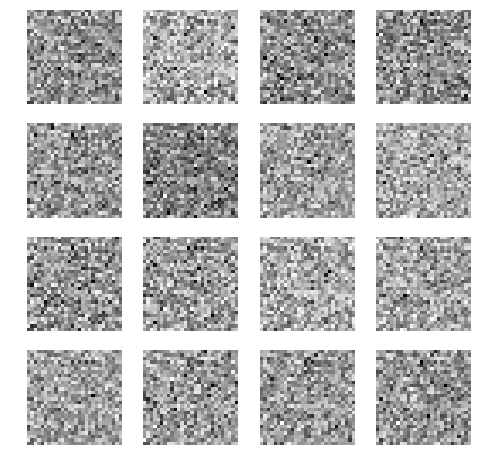

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3940, Generator Loss: 0.6863
D(x): 0.4999, D(G(z)): 0.5036


In [ ]:
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(real_batch.view(real_batch.size(0), 784))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise)
            tools.display_images(test_images, num_test_samples, 
                                 epoch, n_batch, data_folder=DATA_FOLDER)
            # Display Logs
            tools.print_logs(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Checkpoints
        tools.save_checkpoint(generator, discriminator, epoch, data_folder=DATA_FOLDER)